## Importing dependencies

In [328]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import requests
import json
import csv
import math
from datetime import datetime
import calendar
from dateutil.relativedelta import relativedelta
import statistics

## Setting parameters for the Program

In [329]:
# Set begin and end dates for backtesting
begin_date = datetime(2008, 12, 31)
end_date = datetime(2022, 12, 31)

# Set number of months between each restructuring
restructuring_period = 12

# Set number of months to look back for financial data
lookback_period = 6

# Set number of months to look back for pricing for beta
beta_period = 0 # Currently set to 0, to be implemented later

# Set number of portfolios
num_portfolio = 5

# Set industries to not be included in backtesting
industries_excluded = ['Dịch vụ tài chính L2', 'Ngân hàng L2', 'Bảo hiểm L2']

# Set liquidity restriction by value
min_liquidity = 1000000000 #1 Billion VND

# Set which benchmark to use: VNINDEX vs. Basket of stocks in the universe
benchmark = "VNINDEX"

# Set what to print out
data_show = False # Printing out dataframes of raw and cleaned datasets
universe_show = False # Printing out tickers in investable universe
portfolios_show  = False # Printing out tickers in each portfolio at restructuring time
results_show = True # Printing out return & risk metrics of each portfolio

In [330]:
# Get date time series of the starting date of each restructuring period
num_months = (end_date.year - begin_date.year) * 12 + end_date.month - begin_date.month
num_periods = int(num_months / restructuring_period)

start_periods = []
for period in range(num_periods):
    next_period  = begin_date + relativedelta(months = period * restructuring_period) + relativedelta(day=31)
    start_periods.append(next_period)
restructuring_dates = pd.DatetimeIndex(start_periods)

## Loading and Cleaning Data

In [331]:
# Function to get the organCode from list of all tickers
def process(filename:str="/Users/nambuismbp/projects/investment_research/data/codedict.txt") -> dict:
    ticker_to_organ_code = {}
    with open(filename, "r") as json_file:
        data = json.load(json_file)
        ticker_to_organ_code = {
            item["ticker"]: item["organCode"] for item in data["items"]}
        return ticker_to_organ_code
    return None

ticker_dict = process()

# Function to get ticker from the organCode
def get_ticker(val):
    for key, value in ticker_dict.items():
        if val == value:
            return key

In [332]:
# Load in sector data
df_sector = pd.read_csv(r'/Users/nambuismbp/projects/investment_research/data/descriptive_info.csv')
if data_show:
    print(df_sector)
ref_ticker_list = df_sector['Ticker'].to_list()

In [333]:
# Load in pricing data
df_pricing_info = pd.read_csv(r'/Users/nambuismbp/projects/investment_research/data/pricing_data.csv')
if data_show:
    print("Raw Pricing Data, last 5 rows")
    print(df_pricing_info.tail())

# Uniform column name to be ticker
for col in df_pricing_info:
    df_pricing_info.rename(columns = {col: get_ticker(col)}, inplace = True)

# Reverse dataframe to make the dates in ascending order
df_pricing_info = df_pricing_info.reindex(index=df_pricing_info.index[::-1])

# Create new monthly date series based on input data
month_series_pricing = pd.date_range('2008-01-31', periods=len(df_pricing_info), freq='M')
df_pricing_info['month'] = month_series_pricing

# Replace the first column with new date series and set that as index
df_pricing_info = df_pricing_info.drop(df_pricing_info.columns[[0]], axis = "columns")
df_pricing_info.set_index("month", inplace = True)

# Drop companies not in the exchange
df_pricing_info = df_pricing_info[ref_ticker_list]

if data_show:
    print("Processed Pricing Data, last 5 rows")
    print(df_pricing_info.tail())

In [334]:
# Get dataframes of price change in percentage of all stocks
df_pricing_pct_change = df_pricing_info.pct_change()
if data_show:
    print(df_pricing_pct_change)

In [335]:
# Load in trading value data
df_trading_value = pd.read_csv('/Users/nambuismbp/projects/investment_research/data/trading_value_data.csv')
if data_show:
    print("Raw Trading Value Data, last 5 rows")
    print(df_trading_value.tail())

# Uniform column name to be ticker
for col in df_trading_value:
    if col != 'date': df_trading_value.rename(columns = {col: get_ticker(col)}, inplace = True)

# Reverse dataframe to make the dates in ascending order
df_trading_value = df_trading_value.reindex(index=df_trading_value.index[::-1])

# Create new monthly date series based on input data
month_series_tradingval = pd.date_range('2008-01-31', periods=len(df_trading_value), freq='M')
df_trading_value['month'] = month_series_tradingval

# Replace the first column with new date series and set that as index
df_trading_value = df_trading_value.drop(df_trading_value.columns[[0]], axis = "columns")
df_trading_value.set_index("month", inplace = True)

# Drop values of companies not in the exchange
df_trading_value = df_trading_value[ref_ticker_list]

if data_show:
    print("Processed Trading Value Data, last 5 rows")
    print(df_trading_value.tail())

In [336]:
# Load in market returns
df_market_return = pd.read_csv('/Users/nambuismbp/projects/investment_research/data/market_return.csv')

if data_show:
    print("Raw Market Retun Data")
    print(df_market_return)

# Reverse dataframe to make the dates in ascending order
df_market_return = df_market_return.reindex(index=df_market_return.index[::-1])

# Create a new month series to replace the first column
df_market_return = df_market_return.drop(df_market_return.columns[[0]], axis = "columns")

month_series_marketreturn = pd.date_range('2000-07-30', periods=len(df_market_return), freq='M')
df_market_return['month'] = month_series_marketreturn
df_market_return.set_index("month", inplace = True)

if data_show:
    print("Processed Market Return Data")
    print(df_market_return)

In [337]:
# Load in government monthly 10-year bond yields data to represent risk-free rate
df_riskfree_rates = pd.read_csv('/Users/nambuismbp/projects/investment_research/data/vietnam_10yr_bondyield.csv')
if data_show:
    print("Raw Risk Free Rate Data")
    print(df_riskfree_rates)
    
# Reverse dataframe to make the dates in ascending order
df_riskfree_rates = df_riskfree_rates.reindex(index=df_riskfree_rates.index[::-1])

# Create a new month series to replace the first column
df_riskfree_rates = df_riskfree_rates.drop(df_riskfree_rates.columns[[0]], axis = "columns")
month_series_rfreturn = pd.date_range('2007-08-31', periods=len(df_riskfree_rates), freq='M')
df_riskfree_rates['month'] = month_series_rfreturn
df_riskfree_rates.set_index("month", inplace = True)

if data_show:
    print("Processed Risk Free Rate Data")
    print(df_riskfree_rates)

In [338]:
# Load in financial data
with open("/Users/nambuismbp/projects/investment_research/data/financial_data_dec29.txt", 'r') as file:
    financials = json.load(file)

if data_show:
    print(financials)

## Get factor

In [339]:
def show_financial_fields(financials=financials):
    for ticker, items in financials.items():
        fields_list = list(items.keys())
        print("Financial data available in the dataset")
        print(fields_list)
        break

In [340]:
show_financial_fields()

Financial data available in the dataset
['quarters', 'years', 'ebit', 'tangible_capital', 'num_share', 'total_equity', 'total_debt', 'preferred_stock', 'minority_interest']


In [341]:
def get_financial_data(field, financials=financials) -> pd.DataFrame:
    frames = []
    
    for ticker, values in financials.items():
        month_date = []
        data = []
        if len(values['quarters']) > 0:
            for i in range(len(values['quarters'])):
                input_dt = datetime(values['years'][i],values['quarters'][i]*3, 1)
                month_range = calendar.monthrange(input_dt.year, input_dt.month)
                # Get the datetime value based on quarter & year
                get_date = datetime(input_dt.year, input_dt.month, month_range[1])
                month_date.append(get_date)
                # Get the book value
                get_data = values[field][i]
                data.append(get_data)

        # Form a list containing dataframes, each representing one ticker
            df_data_toappend = pd.DataFrame({"quarter": month_date, ticker : data})
            df_data_toappend.set_index("quarter", inplace = True)
            frames.append(df_data_toappend)

    # Concatenate all dataframes along the column axis based on their date indices
    df_data = pd.concat(frames, axis = "columns", join = 'outer')

    # Uniform column name to be ticker
    for col in df_data:
        df_data.rename(columns = {col: get_ticker(col)}, inplace = True)
    
    return df_data

In [342]:
df_numshare = get_financial_data('num_share')
df_numshare = df_numshare[df_numshare.index >= begin_date - relativedelta(months = lookback_period) + relativedelta(day=31)]

df_prices_to_calc = df_pricing_info.loc[df_numshare.index]
df_market_cap = df_numshare * df_prices_to_calc

if data_show:
    print("Book values of companies:")
    print(df_market_cap)

## Screening for investable universe

In [343]:
# Select companies that are not=in financial services, banking, or insurance
df_sector_screened = df_sector[~df_sector['ICB_Sector_L2'].isin(industries_excluded)]
sector_screened_tickerlist = df_sector_screened['Ticker'].tolist()
if universe_show:
    print(f"Screening for industries removed {len(df_sector) - len(df_sector_screened)} companies")

In [344]:
def get_universe() -> dict:
    universe = {}
    for period in restructuring_dates:
        prev_period = period - relativedelta(months = beta_period) + relativedelta(day=31)
        next_period = period + relativedelta(months = restructuring_period) + relativedelta(day=31)
        
        # Drop companies without pricing data available between historical beta period and a given year
        pricing_data_slice = df_pricing_info.loc[period:next_period]
        pricing_data_dropna = pricing_data_slice.dropna(axis = 1)
        pricing_data_available = pricing_data_dropna.columns.tolist()
        
        # Drop companies that do not exceed minimum average daily trading value in a given year
        tradingval_data_slice = df_trading_value.loc[prev_period:next_period, pricing_data_available]
        liquidity_screened_tickerlist = []
        for ticker in tradingval_data_slice:
            tradingval_avg_daily = tradingval_data_slice[ticker].mean() / 21 #Average 21 trading days in a month
            if tradingval_avg_daily > min_liquidity:
                liquidity_screened_tickerlist.append(ticker)
        
        # Drop companies without market cap data available at specified lookback period
        financial_period = period - relativedelta(months = lookback_period) + relativedelta(day=31)
        marketcap_data_slice = df_market_cap.loc[financial_period,:]
        marketcap_data_dropna = marketcap_data_slice.dropna()
        marketcap_data_available = marketcap_data_dropna.index.tolist()
        
        # Get companies that satisfy all screening conditions
        screened_universe = list(set(sector_screened_tickerlist) & set(liquidity_screened_tickerlist) & set(pricing_data_available) & set(marketcap_data_available))
        universe[period] = screened_universe
        
        # Output number of companies meeting each conditions
        if universe_show:
            print(f"In the period between {period.year} and {period.year+1}:")
            print(f"    Pricing data available: {len(pricing_data_available)} companies")
            print(f"    Meeting liquidity restriction: {len(liquidity_screened_tickerlist)} companies")
            print(f"    Market cap data available: {len(marketcap_data_available)} companies")
            print(f"    Investable unierse: {len(screened_universe)} companies")
            print()
    return universe

In [345]:
universe = get_universe()

## Rank factors and form portfolios

In [346]:
def get_portfolios(data_df) -> dict:
    portfolios = {}
    # Get data based on factor ranking
    for period in restructuring_dates:
        financial_period = period - relativedelta(months = lookback_period) + relativedelta(day=31)
        factor_torank = data_df.loc[financial_period, universe[period]]
        factor_torank = factor_torank.squeeze()
        
        # Get ranking based on factor, putting smallest companies in highest portfolio
        ranking = num_portfolio - pd.qcut(factor_torank, num_portfolio, labels = False) - 1 
        portfolios_in_year = []
        
        # Slice to append into list of portfolios from lowest to highest
        for group in range(num_portfolio):
            get_portfolios = ranking[ranking == group].index.tolist()
            portfolios_in_year.append(get_portfolios)
        portfolios[period] = portfolios_in_year
    return portfolios

In [347]:
def print_portfolios(portfolios):
    for period in portfolios:
        for i in range(num_portfolio):
            print(f"At restructuring time {period.date()}, portfolio {i+1} consists of {portfolios[period][i]}")

In [348]:
portfolios = get_portfolios(df_market_cap)
if portfolios_show:
    print_portfolios(portfolios)

## Output Functions: Monthly Returns, Excess Returns, Beta, Std. Deviation, and Alpha

In [349]:
def get_equal_weighted_monthly_returns(portfolios) -> pd.DataFrame:
    allperiods_frames = []
    for date in restructuring_dates:
        begin_period = date + relativedelta(months = 1) + relativedelta(day=31)
        end_period = date + relativedelta(months = restructuring_period) + relativedelta(day=31)
        perperiod_frames = []
        for i in range(num_portfolio):
            # Get list of tickers applicable to a portfolio
            single_portfolio = portfolios[date][i]
            # Get individual stock returns based on tickers
            single_returns = df_pricing_pct_change.loc[begin_period:end_period, single_portfolio]
            # Compute mean returns of all stocks in portfolio in a given month
            mean_returns = single_returns.mean(axis = 1)
            # Get individual dataframes of portfolio returns
            df_toappend = pd.DataFrame({f"Portfolio {i+1}": mean_returns})
            perperiod_frames.append(df_toappend)
        
        # Concatenate dataframes along columns to get all portfolios in a period
        df_larger_toappend = pd.concat(perperiod_frames, axis = "columns", join = 'outer')
        allperiods_frames.append(df_larger_toappend)
        
        # Iterate to the next period
        period = end_period

    # Concatenate dataframes along rows to get all years
    df_returns = pd.concat(allperiods_frames, axis = "rows", join = 'outer')
    return df_returns

In [350]:
df_numshare = get_financial_data('num_share')
def get_value_weighted_monthly_returns(portfolios) -> pd.DataFrame:
    allperiods_frames = []
    for date in restructuring_dates:
        # Get end of months that have returns data
        begin_period = date + relativedelta(months = 1) + relativedelta(day=31)
        end_period = date + relativedelta(months = restructuring_period) + relativedelta(day=31)
        
        perperiod_frames = []
        for i in range(num_portfolio):
            # Get list of tickers applicable to a portfolio
            single_portfolio = portfolios[date][i]
            # Get individual stock returns based on tickers
            single_returns = df_pricing_pct_change.loc[begin_period:end_period, single_portfolio]
            # Get market cap of individual stocks in portfolio at beginning date
            financial_period = date - relativedelta(months = lookback_period) + relativedelta(day=31)
            market_cap = df_pricing_info.loc[date, single_portfolio] * df_numshare.loc[financial_period, single_portfolio]
            # Get weights of individual stocks based on market cap
            weights = []
            for stock in single_portfolio:
                weights.append(market_cap[stock] / market_cap.sum())
            # Compute mean returns of all stocks in portfolio in a given month
            weighted_returns = []
            for index, row in single_returns.iterrows():
                weighted_returns.append(sum([weights[i] * row.to_list()[i] for i in range(len(row.to_list()))]))
            # Get individual dataframes of portfolio returns
            df_toappend = pd.DataFrame({f"Portfolio {i+1}": weighted_returns}, index = single_returns.index)
            perperiod_frames.append(df_toappend)
            
        # Concatenate dataframes along columns to get all portfolios in a period
        df_larger_toappend = pd.concat(perperiod_frames, axis = "columns", join = 'outer')
        allperiods_frames.append(df_larger_toappend)
        
        # Iterate to the next period
        period = end_period

    # Concatenate dataframes along rows to get all years
    df_returns = pd.concat(allperiods_frames, axis = "rows", join = 'outer')
    return df_returns

In [351]:
def get_basket_returns(universe) -> pd.DataFrame:
    allperiods_frames = []
    for date in restructuring_dates:
        begin_period = date + relativedelta(months = 1) + relativedelta(day=31)
        end_period = date + relativedelta(months = restructuring_period) + relativedelta(day=31)
        tickers = universe[date]
        single_returns = df_pricing_pct_change.loc[begin_period:end_period, tickers]
        financial_period = date - relativedelta(months = lookback_period) + relativedelta(day=31)
        market_cap = df_pricing_info.loc[date, tickers] * df_numshare.loc[financial_period, tickers]
        weights = []
        for stock in tickers:
            weights.append(market_cap[stock] / market_cap.sum())
        weighted_returns = []
        for index, row in single_returns.iterrows():
            weighted_returns.append(sum([weights[i] * row.to_list()[i] for i in range(len(row.to_list()))]))
        df_toappend = pd.DataFrame({f"market_return": weighted_returns}, index = single_returns.index)
        allperiods_frames.append(df_toappend)    
    df_returns = pd.concat(allperiods_frames, axis = "rows", join = 'outer') 
    return df_returns

In [352]:
df_basket_returns = get_basket_returns(universe)

In [353]:
def get_excess_monthly_returns(portfolio_returns, riskfree_returns) -> pd.DataFrame:
    # Slice into restructuring period of interest
    riskfree_returns = riskfree_returns.loc[portfolio_returns.index]
    # Divide by 12 to reflect monthly risk-free rate and by 100 to get same magnitude
    riskfree_returns = (riskfree_returns / 12) / 100
    
    excess_ret = []
    for portfolio in portfolio_returns:
        excess_ret.append(portfolio_returns[portfolio] - riskfree_returns['Rate'])
    df_excess_ret = pd.concat(excess_ret, axis = "columns", join = 'outer')
    df_excess_ret.columns = portfolio_returns.columns.to_list()
    return df_excess_ret

In [354]:
def get_cumulative_return(portfolio_returns) -> pd.DataFrame:
    applied_ret = portfolio_returns.loc[begin_date:]
    frames = []
    for portfolio in applied_ret:
        value = (1 + applied_ret[portfolio]).cumprod() - 1 
        df = pd.DataFrame(value)
        frames.append(df)
    df_result = pd.concat(frames, axis = "columns", join = 'outer')
    
    # Adjusting up to normal percentage
    df_result = df_result * 100
    
    return df_result

In [355]:
def get_portfolio_beta(portfolio_excess_returns, market_returns) -> pd.Series:
    market_returns = market_returns.loc[portfolio_excess_returns.index]
    riskfree_rates = (df_riskfree_rates.loc[portfolio_excess_returns.index] / 100) / 12
    mr_minus_mf = pd.DataFrame()
    mr_minus_mf['Market Excess Return'] = market_returns.sub(riskfree_rates['Rate'], axis = 'rows')
    
    beta_dict = {}
    for portfolio in portfolio_excess_returns:
        covar = mr_minus_mf['Market Excess Return'].cov(portfolio_excess_returns[portfolio])
        var = mr_minus_mf['Market Excess Return'].var()
        beta_dict[portfolio] = covar / var
    beta = pd.Series(beta_dict, name='Beta')
    return beta

In [356]:
def get_historical_beta(monthly_price_change, riskfree_returns) -> pd.DataFrame:
    riskfree_rates = (riskfree_returns.loc[monthly_price_change.index] / 12) / 100
    historical_beta = monthly_price_change.sub(riskfree_rates['Rate'], axis = 'rows')
    return historical_beta

In [357]:
def get_portfolio_stdev(portfolio_returns) -> pd.Series:
    stdev = portfolio_returns.std(axis = 0)
    return stdev

In [358]:
def get_portfolio_alpha(avg_portfolio_returns, beta, riskfree_returns, market_returns) -> pd.Series:
    # Slice into restructuring period of interest
    riskfree_returns = (riskfree_returns.loc[begin_date: end_date] / 12) / 100
    market_returns = market_returns.loc[begin_date: end_date]
    market_returns = market_returns
    
    # Get average risk free returns and market return
    rf_avg = riskfree_returns['Rate'].mean()
    mr_avg = market_returns['market_return'].mean()
    
    alpha_dict = {}
    for portfolio, avg_portfolio_ret in avg_portfolio_returns.items():
        avg_excess_ret = avg_portfolio_ret - rf_avg
        expected_ret = beta[portfolio] * (mr_avg - rf_avg)
        get_alpha = avg_excess_ret - expected_ret
        alpha_dict[portfolio] = get_alpha
    alpha = pd.Series(alpha_dict, name='Alpha')
    return alpha

## Portfolio Calculations

In [359]:
ew_monthly_ret = get_equal_weighted_monthly_returns(portfolios)
vw_monthly_ret = get_value_weighted_monthly_returns(portfolios)

In [360]:
ew_avg_ret = ew_monthly_ret.mean(axis = 'rows')
vw_avg_ret = vw_monthly_ret.mean(axis = 'rows')

In [361]:
ew_monthly_xret = get_excess_monthly_returns(ew_monthly_ret, df_riskfree_rates)
vw_monthly_xret = get_excess_monthly_returns(vw_monthly_ret, df_riskfree_rates)

In [362]:
ew_avg_xret = ew_monthly_xret.mean(axis = 'rows')
vw_avg_xret = vw_monthly_xret.mean(axis = 'rows')

In [363]:
ew_std = get_portfolio_stdev(ew_monthly_ret)
vw_std = get_portfolio_stdev(vw_monthly_ret)

In [364]:
if benchmark == "Basket":
    ew_beta = get_portfolio_beta(ew_monthly_xret, df_basket_returns)
    vw_beta = get_portfolio_beta(vw_monthly_xret, df_basket_returns)
elif benchmark == "VNINDEX":
    ew_beta = get_portfolio_beta(ew_monthly_xret, df_market_return)
    vw_beta = get_portfolio_beta(vw_monthly_xret, df_market_return)

In [365]:
if benchmark == "Basket":
    ew_alpha = get_portfolio_alpha(ew_avg_ret, ew_beta, df_riskfree_rates, df_basket_returns)
    vw_alpha = get_portfolio_alpha(vw_avg_ret, vw_beta, df_riskfree_rates, df_basket_returns)
elif benchmark == "VNINDEX":
    ew_alpha = get_portfolio_alpha(ew_avg_ret, ew_beta, df_riskfree_rates, df_market_return)
    vw_alpha = get_portfolio_alpha(vw_avg_ret, vw_beta, df_riskfree_rates, df_market_return)

## Printing out results and export to csv

In [366]:
ew_results = pd.concat({'Avg. Monthly Ret': round(ew_avg_ret * 100, 3), 'Avg. Excess Ret': round(ew_avg_xret * 100, 3), 'Std. Dev': round(ew_std * 100, 3), 'Beta': round(ew_beta, 3), 'Alpha': round(ew_alpha * 100, 3)}, axis = 1)
vw_results = pd.concat({'Avg. Monthly Ret': round(vw_avg_ret * 100, 3), 'Avg. Excess Ret': round(vw_avg_xret * 100, 3), 'Std. Dev': round(vw_std * 100, 3), 'Beta': round(vw_beta, 3), 'Alpha': round(vw_alpha * 100, 3)}, axis = 1)

if results_show:
    print('Result Table for Equal Weighted Portfolios')
    pprint(ew_results)
    print()
    
    print('Result Table for Value Weighted Portfolios')
    pprint(vw_results)

Result Table for Equal Weighted Portfolios
             Avg. Monthly Ret  Avg. Excess Ret  Std. Dev   Beta  Alpha
Portfolio 1             0.966            0.389     7.711  1.051  0.034
Portfolio 2             0.892            0.315     8.168  1.030 -0.033
Portfolio 3             1.514            0.937     8.319  1.020  0.592
Portfolio 4             2.042            1.464     9.221  1.058  1.107
Portfolio 5             3.150            2.573    10.379  1.095  2.203

Result Table for Value Weighted Portfolios
             Avg. Monthly Ret  Avg. Excess Ret  Std. Dev   Beta  Alpha
Portfolio 1             0.685            0.108     7.127  1.001 -0.230
Portfolio 2             0.894            0.316     7.945  1.005 -0.023
Portfolio 3             1.386            0.809     8.327  1.019  0.464
Portfolio 4             1.879            1.302     9.110  1.062  0.943
Portfolio 5             2.621            2.044    10.081  1.066  1.684


In [367]:
ew_cum_ret = get_cumulative_return(ew_monthly_ret)
vw_cum_ret = get_cumulative_return(vw_monthly_ret)

if benchmark == "Basket":
    benchmark_cum_ret = get_cumulative_return(df_basket_returns)
    vw_monthly_ret_with_benchmark = pd.concat([vw_monthly_ret, df_basket_returns], axis = 'columns', join = 'outer')
elif benchmark == "VNINDEX":
    benchmark_cum_ret = get_cumulative_return(df_market_return)
    vw_monthly_ret_with_benchmark = pd.concat([vw_monthly_ret, df_market_return], axis = 'columns', join = 'outer')

## Visualization

In [368]:
vw_monthly_ret_with_benchmark.dropna(inplace = True)
vw_monthly_ret_with_benchmark

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,market_return
month,,,,,,
2009-01-31,-0.051960,-0.016070,-0.034302,-0.020380,-0.010817,-0.03932
2009-02-28,-0.197169,-0.188359,-0.175392,-0.135571,-0.111537,-0.18954
2009-03-31,0.190050,0.154437,0.204043,0.120451,0.227614,0.14226
2009-04-30,0.143453,0.185299,0.172746,0.172425,0.137959,0.14571
2009-05-31,0.200526,0.309644,0.420861,0.308969,0.429677,0.27985
...,...,...,...,...,...,...
2022-08-31,0.051704,0.064599,0.085076,0.057462,0.038610,0.06149
2022-09-30,-0.108690,-0.118715,-0.132789,-0.145025,-0.137040,-0.11589
2022-10-31,-0.106938,-0.182000,-0.159114,-0.212482,-0.224855,-0.09201


In [369]:
df_cum_ret = pd.concat([vw_cum_ret, benchmark_cum_ret], axis = 'columns', join = 'outer')
df_cum_ret

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,Portfolio 5,market_return
month,,,,,,
2008-12-31,NaN,NaN,NaN,NaN,NaN,0.280000
2009-01-31,-5.195994,-1.606954,-3.430172,-2.037983,-1.081668,-3.663010
2009-02-28,-23.888376,-20.140187,-20.367779,-15.318811,-12.114764,-21.922723
2009-03-31,-9.423328,-7.806869,-4.119420,-5.118877,7.889107,-10.815449
2009-04-30,3.570141,9.276402,12.443574,11.241001,22.773366,2.179632
...,...,...,...,...,...,...
2022-08-31,177.088413,305.161277,790.695063,1781.614180,5696.884060,306.856224
2022-09-30,146.971542,257.062510,672.420354,1508.733043,4902.477558,259.705656
2022-10-31,120.560873,192.077034,549.517418,1166.905619,3777.644028,226.609139


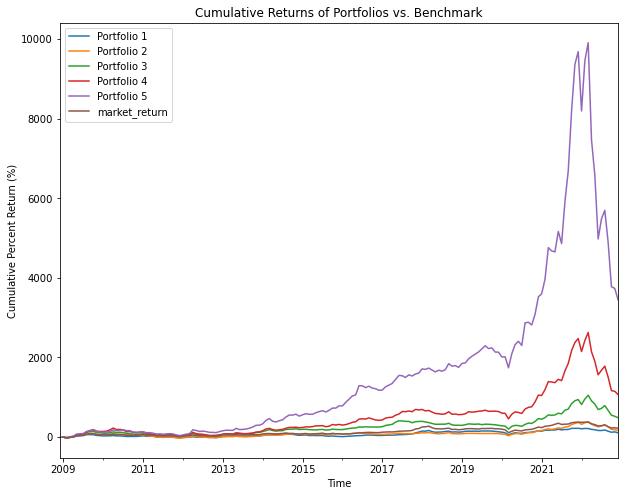

In [370]:
df_cum_ret.plot(kind = 'line', figsize = (10, 8), use_index = True, title = "Cumulative Returns of Portfolios vs. Benchmark", xlabel = "Time", ylabel = "Cumulative Percent Return (%)")
plt.show()